In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# ====================
# Seed Initialization
# ====================
def set_seed(seed_value=42):
    """Fix randomness for reproducibility"""
    random.seed(seed_value)
    np.random.seed(seed_value)

In [3]:
# ====================
# Data Loading & Classes
# ====================

# Class Order:
# This class encapsulates the details of a production order.
# The constructor takes a row (typically a pandas Series from a DataFrame) containing order data.
# It extracts and stores important order attributes including:
# - order_id: A unique identifier for the order.
# - product_type: The type of product being processed (affects machine setup time).
# - cut_time: The time required to perform the cutting stage.
# - sew_time: The time required to perform the sewing stage.
# - pack_time: The time required to perform the packing stage.
# - deadline: The delivery deadline for the order.
# - requires_delay: A flag indicating if a 48 time unit delay is needed after cutting.
class Order:
    def __init__(self, row):
        self.order_id = row['order_id']
        self.product_type = row['Product type']
        self.cut_time = row['cut time']
        self.sew_time = row['sew time']
        self.pack_time = row['pack time']
        self.deadline = row['deadline']
        self.requires_delay = row['requires_out_of_factory_delay']


# Class Machine:
# This class models a machine used in one of the production stages (Cut, Sew, or Pack).
# Each machine is identified by a combination of its type and a unique identifier.
# Key attributes include:
# - machine_id: A unique string identifier (e.g., "Cut-1", "Sew-2").
# - available_at: The time unit when the machine becomes available (initially set to 0).
# - last_product: Stores the last product type processed to determine if a setup time is needed.
# - utilization: A list that records the start and end times of tasks performed by the machine.
class Machine:
    def __init__(self, machine_type, machine_id):
        self.machine_id = f"{machine_type}-{machine_id}"
        self.available_at = 0
        self.last_product = None
        self.utilization = []


# Function load_data:
# This function is responsible for reading the production order data from a CSV file.
# It uses pandas to load the data and then processes the 'requires_out_of_factory_delay' column:
# 1. The CSV file is read from the specified csv_path.
# 2. The 'requires_out_of_factory_delay' column is converted to a string, made uppercase,
#    and then mapped to boolean values: 'TRUE' becomes True, and 'FALSE' becomes False.
# 3. The function returns the processed DataFrame containing the order information.
def load_data(csv_path):
    df = pd.read_csv(csv_path)
    df['requires_out_of_factory_delay'] = df['requires_out_of_factory_delay'].astype(str).str.upper().map({
        'TRUE': True,
        'FALSE': False
    })
    return df


In [4]:
# ====================
# Scheduling Core
# ====================

def simulate_schedule(orders):
    """
    Simulates the production process for a list of orders by scheduling them through three sequential stages: Cutting, Sewing, and Packing.
    
    The function performs the following steps:
      1. Initializes machines for each stage:
         - Two cutting machines.
         - Three sewing machines.
         - One packing machine.
      2. Processes each order sequentially:
         - Cutting Stage:
             * For each cutting machine, it calculates a potential start time.
             * A 10 time-unit setup time is added if the current order's product type differs from the last processed product.
             * The machine with the earliest start time is selected, and its available time is updated after processing.
         - Post-Cutting Delay:
             * If the order requires an out-of-factory delay, a 48 time-unit delay is added after the cutting stage.
         - Sewing Stage:
             * For each sewing machine, it determines the start time based on the machine's availability and the post-cut delay.
             * The sewing machine that can start earliest is selected, and its available time is updated accordingly.
         - Packing Stage:
             * The packing stage begins when the packing machine is available and after the sewing stage is completed.
             * The packing machine’s available time is updated after processing.
      3. Lateness Calculation:
         - Lateness is computed as the positive difference between the packing completion time and the order’s deadline.
         - Total lateness is accumulated, and on-time orders (lateness == 0) are counted.
      4. Scheduling Information:
         - The schedule for each order, including assigned machines and start/end times for each stage, is recorded.
    
    Returns a tuple containing:
      - schedule: A dictionary mapping each order ID to its scheduling details (Cut, Sew, Pack, Lateness).
      - lateness_summary: A dictionary mapping each order ID to its computed lateness.
      - total_lateness: The overall lateness accumulated across all orders.
      - on_time_count: The count of orders completed on time.
      - A list of final available times for the cutting machines.
      - A list of final available times for the sewing machines.
      - The final available time for the packing machine.
    """
    # Initialize machines for each production stage
    cutting_machines = [Machine('Cut', i + 1) for i in range(2)]
    sewing_machines = [Machine('Sew', i + 1) for i in range(3)]
    packing_machine = Machine('Pack', 1)

    # Initialize scheduling records and performance metrics
    schedule = {}
    lateness_summary = {}
    total_lateness = 0
    on_time_count = 0

    # Process each order sequentially
    for order in orders:
        # --------------------
        # Cutting Stage
        # --------------------
        # Evaluate all cutting machines to determine the earliest start time for this order.
        cut_options = []
        for machine in cutting_machines:
            # Add setup time of 10 units if the product type is different from the last processed product.
            setup = 10 if (machine.last_product and machine.last_product != order.product_type) else 0
            start_time = machine.available_at + setup
            cut_options.append((start_time, machine))

        # Select the cutting machine with the earliest available start time.
        start_cut, best_cut_machine = min(cut_options, key=lambda x: x[0])
        end_cut = start_cut + order.cut_time  # Calculate end time for the cutting stage.
        best_cut_machine.available_at = end_cut  # Update machine availability.
        best_cut_machine.last_product = order.product_type  # Record the product type processed.
        best_cut_machine.utilization.append((start_cut, end_cut))  # Log the machine's utilization.

        # --------------------
        # Post-Cutting Delay
        # --------------------
        # If the order requires an out-of-factory delay, add 48 time units after cutting.
        sew_ready_time = end_cut + (48 if order.requires_delay else 0)

        # --------------------
        # Sewing Stage
        # --------------------
        # Evaluate all sewing machines to determine the earliest start time for the sewing stage.
        sew_options = []
        for machine in sewing_machines:
            # Start time is the later of the machine's availability or the time after the post-cut delay.
            start_time = max(machine.available_at, sew_ready_time)
            sew_options.append((start_time, machine))

        # Select the sewing machine with the earliest available start time.
        start_sew, best_sew_machine = min(sew_options, key=lambda x: x[0])
        end_sew = start_sew + order.sew_time  # Calculate end time for the sewing stage.
        best_sew_machine.available_at = end_sew  # Update machine availability.
        best_sew_machine.utilization.append((start_sew, end_sew))  # Log the machine's utilization.

        # --------------------
        # Packing Stage
        # --------------------
        # Schedule the packing stage to start after the sewing stage is complete and the packing machine is available.
        start_pack = max(packing_machine.available_at, end_sew)
        end_pack = start_pack + order.pack_time  # Calculate end time for packing.

        # Check to ensure that the packing machine is available (should always be true if logic is correct).
        if start_pack < packing_machine.available_at:
            raise ValueError(f"Packing conflict in order {order.order_id}")

        packing_machine.available_at = end_pack  # Update packing machine availability.
        packing_machine.utilization.append((start_pack, end_pack))  # Log the machine's utilization.

        # --------------------
        # Lateness Calculation
        # --------------------
        # Compute lateness as the positive difference between the finishing time of packing and the order's deadline.
        lateness = max(0, end_pack - order.deadline)
        total_lateness += lateness  # Accumulate the total lateness.
        on_time_count += 1 if lateness == 0 else 0  # Count the order as on time if there's no lateness.

        # Record the scheduling details for the order.
        schedule[order.order_id] = {
            'Cut': (best_cut_machine.machine_id, start_cut, end_cut),
            'Sew': (best_sew_machine.machine_id, start_sew, end_sew),
            'Pack': (packing_machine.machine_id, start_pack, end_pack),
            'Lateness': lateness
        }
        lateness_summary[order.order_id] = lateness

    # Return the complete schedule along with performance metrics.
    return (
        schedule,
        lateness_summary,
        total_lateness,
        on_time_count,
        [m.available_at for m in cutting_machines],
        [m.available_at for m in sewing_machines],
        packing_machine.available_at
    )


In [5]:
# ====================
# Permutation Generator
# ====================

def generate_permutation(orders):
    """
    Generates a new permutation (ordering) of the provided orders based on one of three heuristics.
    
    The function randomly selects one heuristic to reorder the orders:
      - Deadline Heuristic (60% chance): 
          * Orders are sorted by their deadline.
          * Orders with the same deadline are grouped together.
          * Groups are shuffled internally to introduce variability.
      - Product Type Heuristic (20% chance): 
          * Orders are sorted by their product type.
          * Orders with the same product type are grouped together.
          * Groups are shuffled internally to introduce variability.
      - Processing Time Heuristic (20% chance):
          * Orders are sorted by their total processing time (cut_time + sew_time + pack_time).
          * Orders with the same total processing time are grouped together.
          * Groups are shuffled internally to introduce variability.
    
    Returns:
      - A shuffled list of orders according to the selected heuristic.
      - A string indicating the heuristic used ('deadline', 'product', or 'processing_time').
    """
    r = random.random()
    if r < 0.6:  # Deadline heuristic (60%)
        sorted_orders = sorted(orders, key=lambda x: x.deadline)
        groups = {}
        for order in sorted_orders:
            key = order.deadline
            if key not in groups:
                groups[key] = []
            groups[key].append(order)
        shuffled = []
        for key in sorted(groups.keys()):
            random.shuffle(groups[key])
            shuffled.extend(groups[key])
        return shuffled, 'deadline'
    
    elif r < 0.8:  # Product type heuristic (20%)
        sorted_orders = sorted(orders, key=lambda x: x.product_type)
        groups = {}
        for order in sorted_orders:
            key = order.product_type
            if key not in groups:
                groups[key] = []
            groups[key].append(order)
        shuffled = []
        for key in sorted(groups.keys()):
            random.shuffle(groups[key])
            shuffled.extend(groups[key])
        return shuffled, 'product'
    
    else:  # Processing time heuristic (20%)
        sorted_orders = sorted(orders, key=lambda x: (x.cut_time + x.sew_time + x.pack_time))
        groups = {}
        for order in sorted_orders:
            key = order.cut_time + order.sew_time + order.pack_time
            if key not in groups:
                groups[key] = []
            groups[key].append(order)
        shuffled = []
        for key in sorted(groups.keys()):
            random.shuffle(groups[key])
            shuffled.extend(groups[key])
        return shuffled, 'processing_time'

# ====================
# Optimization Engine
# ====================

def optimize_schedules(data, iterations=500):
    """
    Optimization Engine: Runs a Monte Carlo simulation to find the optimal production schedule.
    
    Steps:
      1. Convert the input DataFrame into a list of Order objects.
      2. Initialize a dictionary to track the best schedule based on:
         - Maximum number of orders completed on time.
         - Minimum total lateness (when on-time counts are equal).
      3. For a specified number of iterations:
         - Generate a new permutation of orders using the generate_permutation function.
         - Simulate the production schedule using simulate_schedule.
         - Update the best schedule if the current one yields a higher on-time count,
           or if the on-time count is equal but the total lateness is lower.
         - Record the performance metrics (on-time count, total lateness, heuristic used) for visualization.
      4. Return the best schedule along with histories of on-time counts, total lateness, and heuristics.
    
    Returns:
      - best: Dictionary containing the best schedule and associated performance metrics.
      - on_time_history: List tracking the best on-time order count over iterations.
      - total_lateness_history: List tracking the total lateness over iterations.
      - heuristic_history: List recording the heuristic used in each iteration.
    """
    orders = [Order(row) for _, row in data.iterrows()]
    best = {
        'on_time': -1,
        'lateness': float('inf'),
        'schedule': None,
        'cut_util': [],
        'sew_util': [],
        'pack_util': 0,
        'lateness_map': {},
        'heuristic': None
    }
    
    on_time_history = []
    total_lateness_history = []
    heuristic_history = []

    for _ in tqdm(range(iterations), desc='Optimizing'):
        permuted, heuristic = generate_permutation(orders.copy())
        try:
            schedule, lateness_map, total_lat, on_time, cut_util, sew_util, pack_util = simulate_schedule(permuted)
        except ValueError:
            continue

        # Update the best schedule if the current one has more on-time orders or,
        # when tied, lower total lateness.
        if (on_time > best['on_time']) or (on_time == best['on_time'] and total_lat < best['lateness']):
            best.update({
                'on_time': on_time,
                'lateness': total_lat,
                'schedule': schedule,
                'cut_util': cut_util,
                'sew_util': sew_util,
                'pack_util': pack_util,
                'lateness_map': lateness_map,
                'heuristic': heuristic
            })

        on_time_history.append(best['on_time'])
        total_lateness_history.append(best['lateness'])
        heuristic_history.append(heuristic)

    return best, on_time_history, total_lateness_history, heuristic_history

# ====================
# Visualization Functions
# ====================

def plot_machine_timeline(schedule):
    """
    Visualizes the machine utilization timeline using a Gantt chart.
    
    Steps:
      1. Iterate through the schedule to aggregate tasks per machine.
      2. For each machine, collect all tasks (order ID, start time, end time).
      3. Create a horizontal bar chart where each bar represents a task's duration on the machine.
      4. Label the x-axis (Time Units) and set a title for the chart.
      5. Display the Gantt chart to illustrate machine utilization over time.
    """
    machines = {}
    for order_id, stages in schedule.items():
        for stage in ['Cut', 'Sew', 'Pack']:
            machine_id, start, end = stages[stage]
            if machine_id not in machines:
                machines[machine_id] = []
            machines[machine_id].append((order_id, start, end))
    
    fig, ax = plt.subplots(figsize=(15, 8))
    colors = plt.cm.tab20.colors
    
    for idx, (machine, tasks) in enumerate(machines.items()):
        for task in tasks:
            order_id, start, end = task
            ax.barh(y=machine, width=end-start, left=start, 
                    color=colors[idx % 20], edgecolor='black')
    
    ax.set_xlabel('Time Units')
    ax.set_title('Machine Utilization Timeline')
    plt.tight_layout()
    plt.show()

def plot_optimization_progress(on_time_history, lateness_history):
    """
    Plots the optimization progress over simulation iterations.
    
    This dual-axis plot shows:
      - On-time order counts (primary y-axis, green line).
      - Total lateness (secondary y-axis, red dashed line).
    
    Steps:
      1. Plot on-time order counts on the primary y-axis.
      2. Plot total lateness on a secondary (twin) y-axis.
      3. Set the x-axis label (Iteration) and respective y-axis labels.
      4. Display the plot to show how the schedule improves over iterations.
    """
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # On-Time Orders plot on primary y-axis
    ax1.plot(on_time_history, color='green', label='On-Time Orders')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('On-Time Orders', color='green')
    ax1.tick_params(axis='y', labelcolor='green')
    
    # Total Lateness plot on secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(lateness_history, color='red', linestyle='--', label='Total Lateness')
    ax2.set_ylabel('Total Lateness', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    plt.title('Optimization Progress')
    fig.tight_layout()
    plt.show()

def plot_lateness_distribution(lateness_map):
    """
    Visualizes the lateness distribution across orders using a bar chart.
    
    Steps:
      1. Sort the lateness values in descending order.
      2. Extract order IDs and their corresponding lateness values.
      3. Create a bar chart with order IDs on the x-axis and lateness (time units) on the y-axis.
      4. Add a horizontal reference line at zero to indicate on-time completion.
      5. Label the axes, set the title, and display the chart.
    """
    sorted_lateness = sorted(lateness_map.items(), key=lambda x: x[1], reverse=True)
    order_ids = [x[0] for x in sorted_lateness]
    lateness = [x[1] for x in sorted_lateness]
    
    plt.figure(figsize=(15, 6))
    bars = plt.bar(order_ids, lateness, color='salmon')
    plt.axhline(0, color='black', linewidth=0.8)
    plt.xlabel('Order ID')
    plt.ylabel('Lateness (Time Units)')
    plt.title('Lateness Distribution by Order')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--')
    plt.show()

def plot_heuristic_breakdown(heuristic_history):
    """
    Generates a pie chart showing the distribution of heuristics used during the simulation.
    
    Steps:
      1. Count the occurrences of each heuristic type (Deadline, Product Type, Processing Time).
      2. Create a pie chart to visualize the proportional use of each heuristic.
      3. Set a title for the chart and display it.
    """
    counts = {
        'Deadline': heuristic_history.count('deadline'),
        'Product Type': heuristic_history.count('product'),
        'Processing Time': heuristic_history.count('processing_time')
    }
    
    plt.figure(figsize=(8, 8))
    plt.pie(counts.values(), labels=counts.keys(), autopct='%1.1f%%',
            colors=['#66b3ff', '#99ff99', '#ffcc99'])
    plt.title('Heuristic Distribution in Monte Carlo Simulation')
    plt.show()


Optimizing: 100%|██████████| 500/500 [00:00<00:00, 4401.88it/s]



=== Schedule Performance ===
i. Total orders completed on time: 20/50
ii. Average time units late: 107.72

iii. Summary of lateness by order:
Order O001: 145 units late
Order O002: 0 units late
Order O003: 122 units late
Order O004: 273 units late
Order O005: 0 units late
Order O006: 85 units late
Order O007: 326 units late
Order O008: 0 units late
Order O009: 0 units late
Order O010: 78 units late
Order O011: 65 units late
Order O012: 0 units late
Order O013: 41 units late
Order O014: 0 units late
Order O015: 341 units late
Order O016: 0 units late
Order O017: 430 units late
Order O018: 126 units late
Order O019: 410 units late
Order O020: 0 units late
Order O021: 0 units late
Order O022: 0 units late
Order O023: 0 units late
Order O024: 60 units late
Order O025: 162 units late
Order O026: 0 units late
Order O027: 224 units late
Order O028: 36 units late
Order O029: 168 units late
Order O030: 261 units late
Order O031: 0 units late
Order O032: 0 units late
Order O033: 171 units late


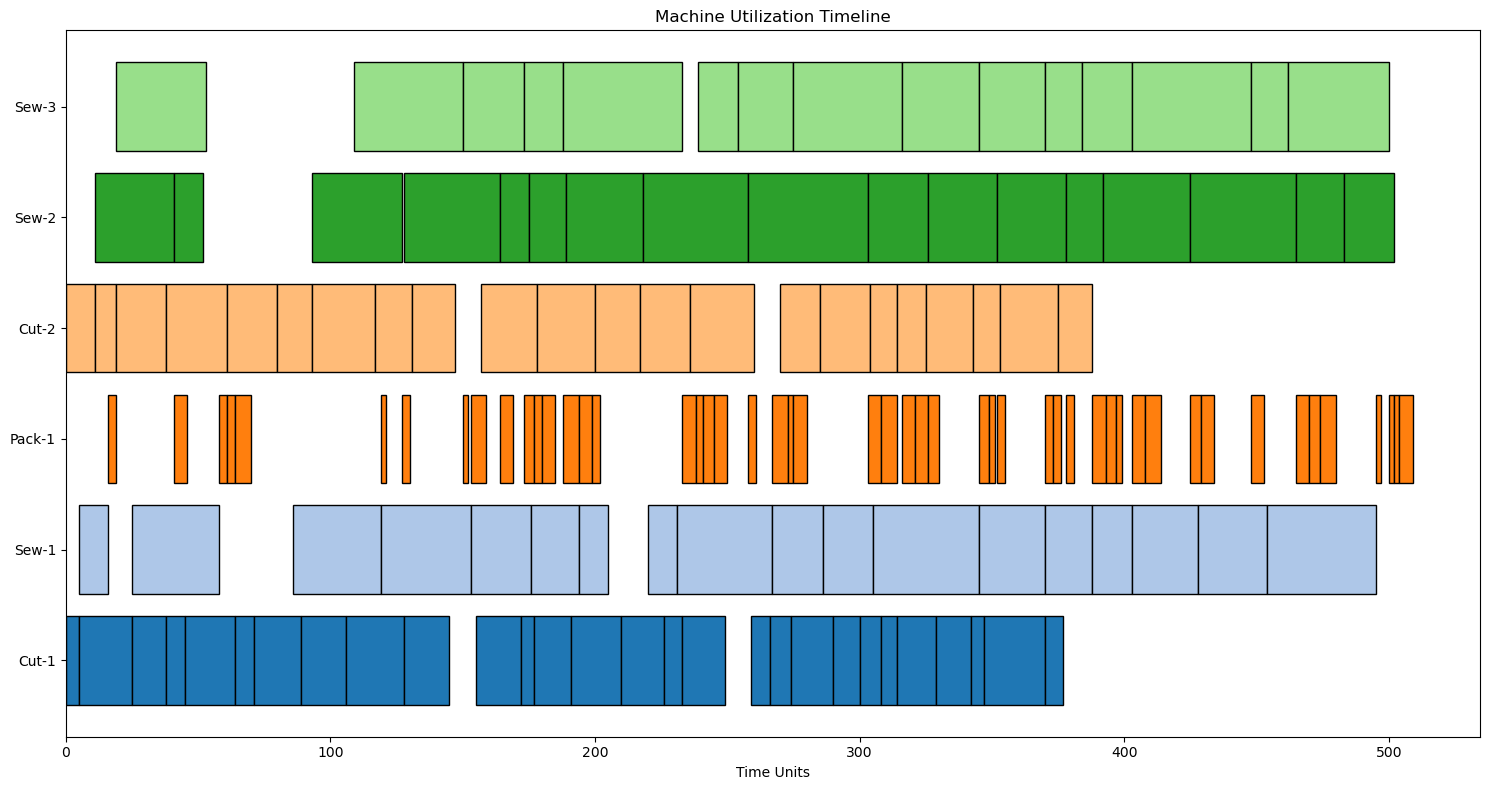

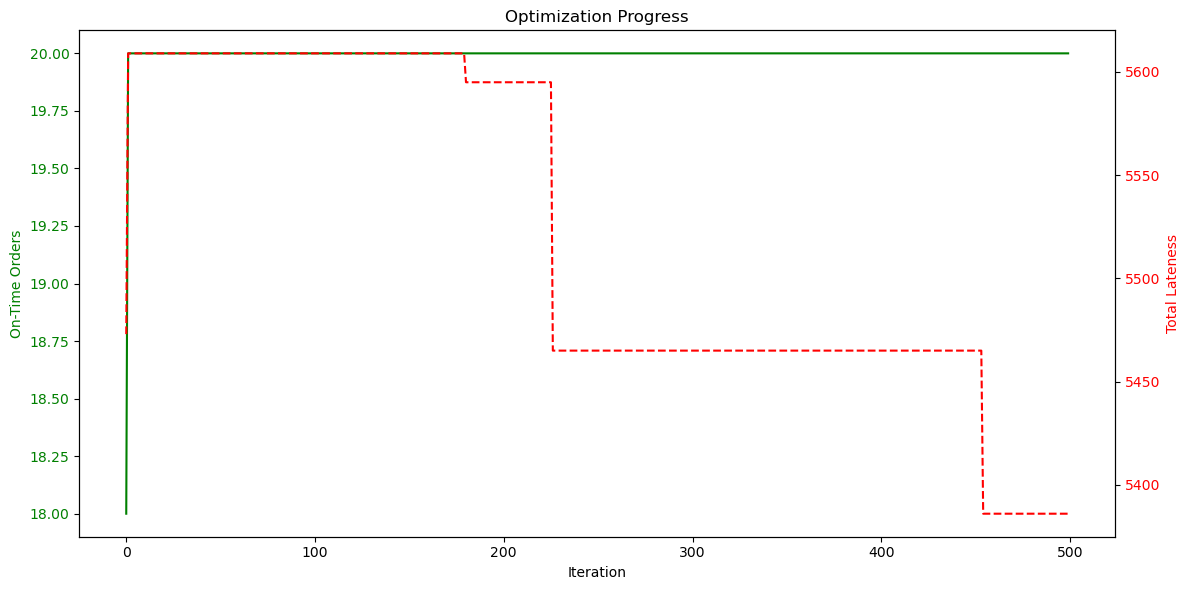

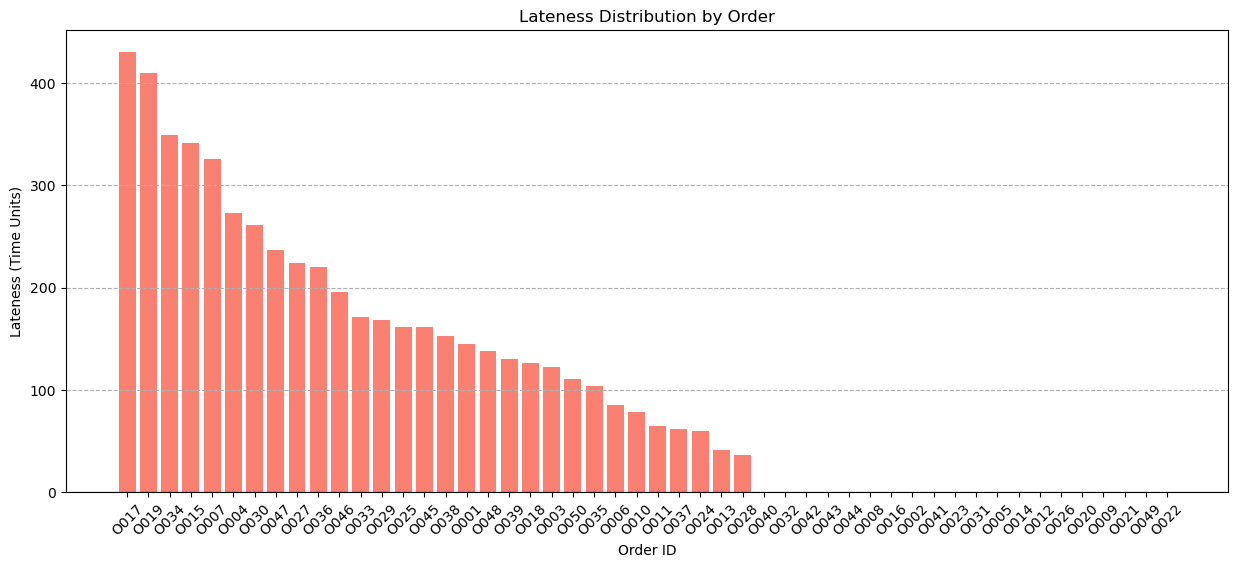

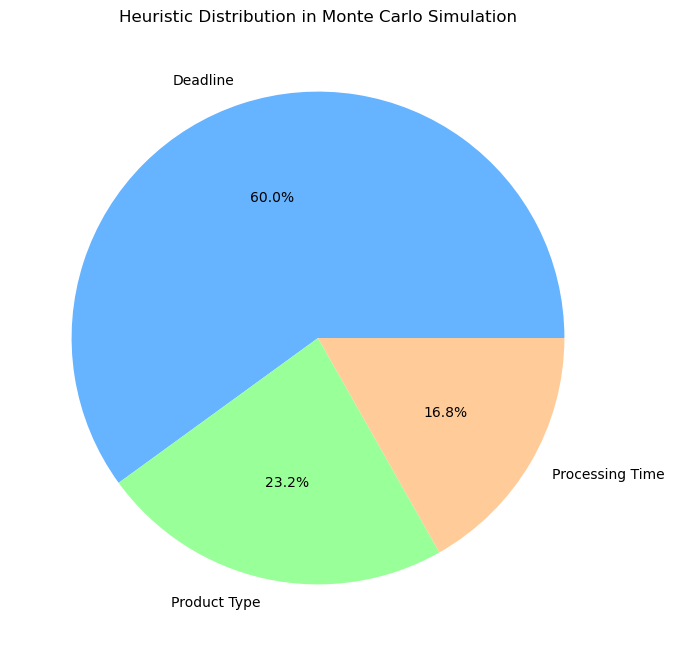

In [6]:
# ====================
# Main Execution
# ====================
if __name__ == "__main__":
    """
    Main Execution:
    ---------------
    This section serves as the entry point for running the entire production scheduling simulation.
    
    Steps Performed:
    1. Set the random seed for reproducibility:
       - The seed is set to 42 to ensure that any randomness (e.g., in permutations and simulations)
         produces consistent results across runs.
    
    2. Load Order Data:
       - The DATA_PATH variable is defined with the path to the CSV file containing the order data.
       - The load_data() function reads the CSV file, processing it to ensure the 'requires_out_of_factory_delay'
         column is correctly converted into boolean values.
    
    3. Run the Optimization Engine:
       - The optimize_schedules() function is called with the loaded DataFrame and a defined number of iterations (500).
       - This function performs a Monte Carlo simulation to generate various permutations of the orders,
         simulates the production process for each permutation, and evaluates performance based on on-time 
         completions and lateness.
       - It returns the best schedule found along with historical data for on-time counts, total lateness,
         and the heuristics used.
    
    4. Output the Results:
       - The performance of the best schedule is printed to the console:
           * Total orders completed on time.
           * Average lateness per order.
           * A detailed summary of lateness for each order.
    
    5. Visualize the Results:
       - The machine utilization timeline, optimization progress, lateness distribution, and heuristic breakdown
         are visualized using the corresponding plotting functions.
    
    This block integrates the overall workflow: data loading, simulation, result analysis, and visualization,
    thereby providing a complete run-through of the scheduling simulation.
    """
    set_seed(42)
    DATA_PATH = '/Users/syedakash/Desktop/Data for technical assessment - Sheet1.csv'
    orders_df = load_data(DATA_PATH)
    best_result, on_time_hist, lateness_hist, heuristic_hist = optimize_schedules(orders_df, iterations=500)

    # Print required output
    print("\n=== Schedule Performance ===")
    print(f"i. Total orders completed on time: {best_result['on_time']}/{len(orders_df)}")
    print(f"ii. Average time units late: {best_result['lateness']/len(orders_df):.2f}")
    print("\niii. Summary of lateness by order:")
    for order_id, lateness in sorted(best_result['lateness_map'].items(), key=lambda x: x[0]):
        print(f"Order {order_id}: {lateness} units late")

    # Generate visualizations
    plot_machine_timeline(best_result['schedule'])
    plot_optimization_progress(on_time_hist, lateness_hist)
    plot_lateness_distribution(best_result['lateness_map'])
    plot_heuristic_breakdown(heuristic_hist)
